# Understanding the Objective
 *  The goal is to **predict the salary** of data related positions based on location, company review and job title

*  (for Classification Models) The goal is to predict whether the salary for data-related positions, based on location, company reviews, and job title, is **satisfactory** or not.

# Import Libraries

In [14]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Read the data

In [15]:
raw_data = pd.read_csv('df.csv')

# Data Understanding

In [16]:
raw_data.head(3)

,Job Title,Salary Estimate,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),3.5,Hopper\n3.5,"New York, NY",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),4.5,Noom US\n4.5,"New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable
2,Data Science Manager,$111K-$181K (Glassdoor est.),-1.0,Decode_M,"New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable


A few quick things come to mind looking at the above data:

1. Job titles can be categorized based on the words they contain such as "director", "data analyst", ...
2. Make the list of max and min salary and then average them. Then rename column to average salary which will be our response variable
3. Company names should not matter much
4. The state where each position is located can be extracted from the location column
5. Because there are too many unknowns in the Revenue column, we will not use that column

# Assess data

In this section, we will check the raw data and get an understanding of what kind of data we are dealing with.



In [17]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          5892 non-null   object 
 1   Salary Estimate    5892 non-null   object 
 2   Rating             5892 non-null   float64
 3   Company Name       5892 non-null   object 
 4   Location           5892 non-null   object 
 5   Size               5892 non-null   object 
 6   Founded            5892 non-null   object 
 7   Type of ownership  5892 non-null   object 
 8   Industry           5892 non-null   object 
 9   Sector             5892 non-null   object 
 10  Revenue            5892 non-null   object 
dtypes: float64(1), object(10)
memory usage: 506.5+ KB


# Clean Data



*  Put out numbers of Salary Estimate as a list

*  Keep the lists with two item and average salary

* Extracted the state where each position is located. Rename column to state

* Title column was created to show the different categories for the posted roles such as data engineer, deep learning, analyst, ...







## Clean 'Salary Estimate' as 'Average Salary'

In [18]:
# Remove Per Hour salary. We only want a salary range of one year
df = raw_data[~raw_data['Salary Estimate'].str.contains('Per Hour')]

In [19]:
# Pick out numbers from str
def str_num(string):
  import re
  temp = re.findall(r'-?\d+', string)
  res = list(map(int, temp))
  return res

In [20]:
df['Salary Estimate'] = df['Salary Estimate'].apply(str_num)

C:\Users\Marina\AppData\Local\Temp\ipykernel_8420\3861853995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Salary Estimate'] = df['Salary Estimate'].apply(str_num)


In [21]:
# Remove -1 (anything that doesn't have two number for a range of salary)
def del_n1(salary):
    if len(salary) < 2:
        return None
    return salary

In [22]:
df['Salary Estimate'] = df['Salary Estimate'].apply(del_n1)
df = df.dropna(subset=['Salary Estimate']).reset_index(drop=True)

C:\Users\Marina\AppData\Local\Temp\ipykernel_8420\18994302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Salary Estimate'] = df['Salary Estimate'].apply(del_n1)


In [23]:
# Make the average of its range
df['Salary Estimate'] = df['Salary Estimate'].apply(statistics.mean)

In [24]:
# rename 'Salary Estimate' to 'Average Salery'
df.rename(columns = {'Salary Estimate':'Average_Salary'}, inplace = True)

## Clean 'Location' as 'State'

In [25]:
# split 'location' and bring last part (state)
def state(l):
  l = l.split()[-1]
  return l

In [26]:
df['Location'] = df['Location'].apply(state)
# rename 'Location' to 'state'
df.rename(columns = {'Location':'State'}, inplace = True)

In [27]:
# U.S doesn't have Kingdom
df = df[df['State'] != 'Kingdom']

## Clean 'Rating'

In [28]:
# Remove negetive numbers
def del_negetive_num(n):
  if n < 0:
    return None
  return(n)

In [29]:
# or just remove -1
# df = df[df['Rating']!=-1]

In [30]:
df['Rating'] = df['Rating'].apply(del_negetive_num)
df = df.dropna(subset=['Rating']).reset_index(drop=True)

## Clean 'Job Title'

In [31]:
def title_organizer(x):
        """
        This function organizes the job title
        """
        x = x.lower()
        if ('data scientist' in x) or ('data science' in x) :
            return 'data scientist'
        elif 'data engineer' in x:
            return 'data engineer'
        elif 'deep learning' in x:
            return 'deep learning engineer'
        elif 'machine learning' in x:
            return 'machine learning engineer'
        elif 'director' in x:
            return 'director'
        elif 'manager' in x:
            return 'manager'
        elif 'analyst' in x:
            return 'analyst'
        elif 'researcher' in x:
            return 'researcher'
        else:
            return 'other'

In [32]:
df['Job Title'] = df['Job Title'].apply(title_organizer)

## Take out columns we need

In [ ]:
cleaned_df = df[['Job Title', 'Rating', 'Average_Salary', 'State']]

In [34]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891 entries, 0 to 4890
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Job Title       4891 non-null   object 
 1   Rating          4891 non-null   float64
 2   Average_Salary  4891 non-null   float64
 3   State           4891 non-null   object 
dtypes: float64(2), object(2)
memory usage: 153.0+ KB


In [35]:
cleaned_df.describe()

,Rating,Average_Salary
count,4891.000000,4891.000000
mean,3.817011,106.082192
std,0.577004,35.749097
min,1.000000,37.500000
25%,3.500000,77.500000
50%,3.800000,102.000000
75%,4.100000,130.000000
max,5.000000,268.000000


# Exploratory Data Analysis (EDA)

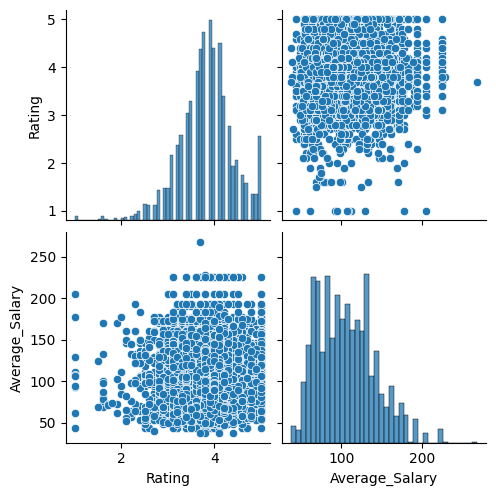

In [36]:
sns.pairplot(cleaned_df)

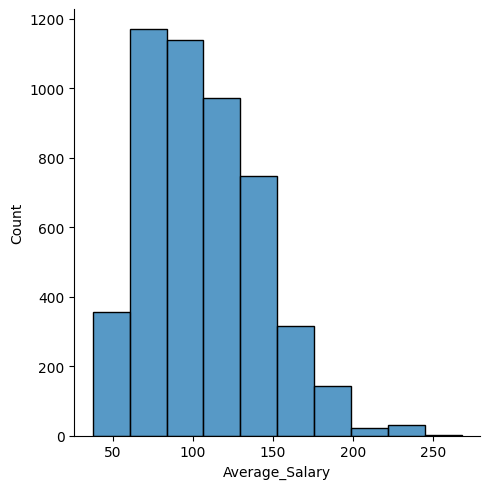

In [37]:
sns.displot(x='Average_Salary', data= cleaned_df, bins = 10)

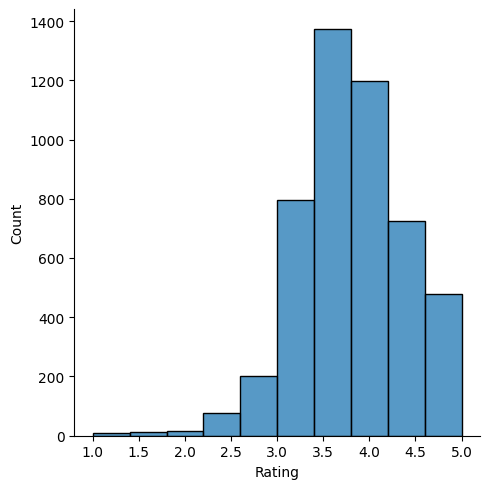

In [38]:
sns.displot(x='Rating', data= cleaned_df, bins = 10)

C:\Users\Marina\AppData\Local\Temp\ipykernel_8420\729256471.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Job Title', data= cleaned_df, palette='husl')


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'data scientist'),
  Text(1, 0, 'analyst'),
  Text(2, 0, 'researcher'),
  Text(3, 0, 'other'),
  Text(4, 0, 'data engineer'),
  Text(5, 0, 'manager'),
  Text(6, 0, 'machine learning engineer'),
  Text(7, 0, 'director'),
  Text(8, 0, 'deep learning engineer')])

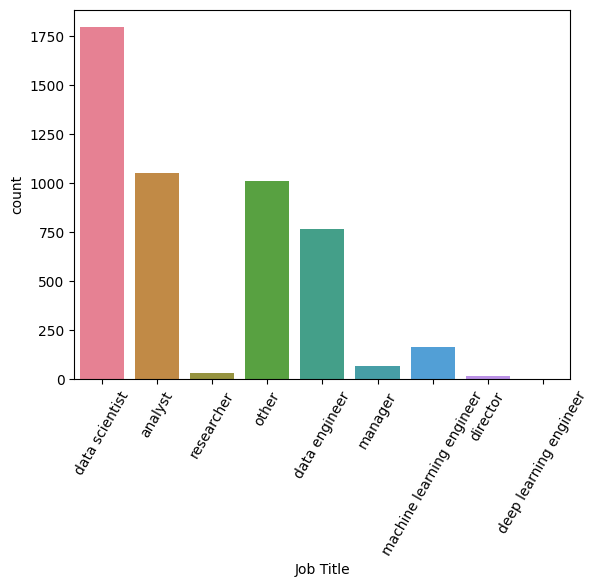

In [39]:
sns.countplot(x='Job Title', data= cleaned_df, palette='husl')
plt.xticks(rotation= 60)

<Axes: xlabel='Rating', ylabel='Average_Salary'>

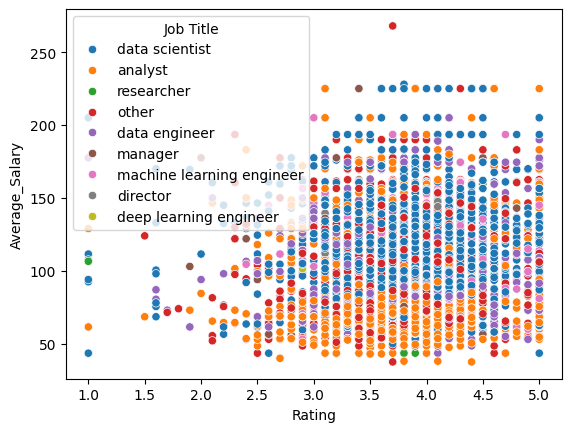

In [40]:
sns.scatterplot(x='Rating', y='Average_Salary', data= cleaned_df, hue='Job Title')

# Feature Engineering

In [41]:
preprocessed_df = pd.get_dummies(cleaned_df, columns=['Job Title','State'])

## for Regression Model

In [42]:
X = preprocessed_df.drop(columns='Average_Salary')

In [43]:
y = preprocessed_df['Average_Salary']

## for Classification Models

In [44]:
preprocessed_df['Average_Salary'].median()

np.float64(102.0)

In [45]:
def sat(x):
  if x>= 102:
    return(1)
  else:
    return(0)

In [46]:
preprocessed_df['Satisfaction'] = preprocessed_df['Average_Salary'].apply(sat)

In [47]:
x = preprocessed_df.drop(columns=['Average_Salary', 'Satisfaction'])

In [48]:
Y = preprocessed_df['Satisfaction']

# Modeling

We use **Supervised Learning**

 -- because our data is labaled

## Regression Model

use Linear Regression

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 101)

In [50]:
lr = LinearRegression()

In [51]:
lr.fit(X_train,y_train)

LinearRegression()

In [52]:
# print the intercept(b0)
print(lr.intercept_)

92787247719047.8


In [53]:
# print the coefficients(b1, b2, ...)
print(lr.coef_)

[ 2.24685151e+00  6.47920631e+14  6.47920631e+14  6.47920631e+14
  6.47920631e+14  6.47920631e+14  6.47920631e+14  6.47920631e+14
  6.47920631e+14  6.47920631e+14 -7.40707879e+14 -7.40707879e+14
 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14
 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14
 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14
 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14
 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14 -7.40707879e+14
 -7.40707879e+14]


In [54]:
# Prediction
predictions = lr.predict(X_test)
predictions

array([ 92.296875, 125.3125  ,  89.796875, ...,  83.921875,  92.421875,
        90.046875])

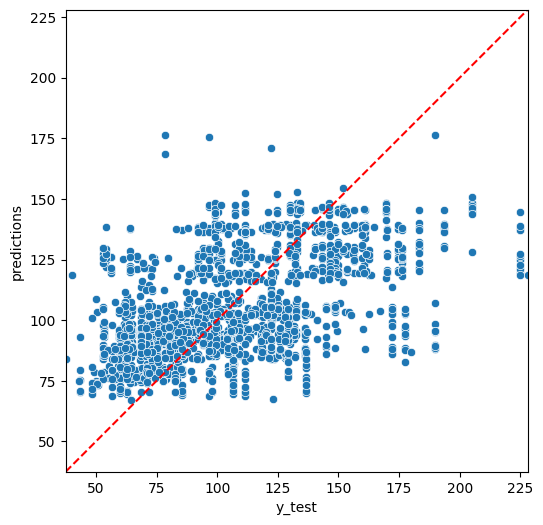

In [55]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=predictions)

plt.xlabel('y_test')
plt.ylabel('predictions')
min_val = min(min(y_test), min(predictions))
max_val = max(max(y_test), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', adjustable='box')

In [56]:
residual= y_test-predictions

C:\Users\Marina\AppData\Local\Temp\ipykernel_8420\166987202.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual,bins=50);


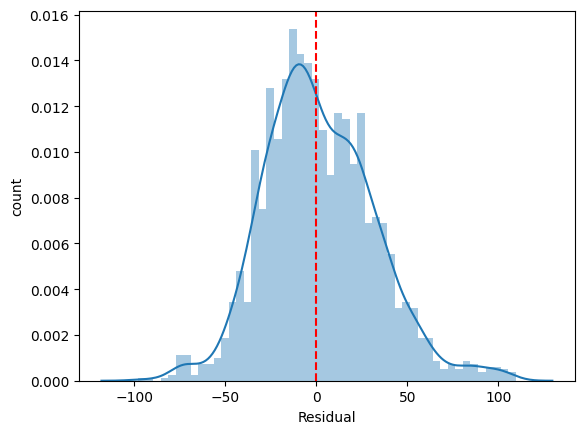

In [57]:
sns.distplot(residual,bins=50);
plt.ylabel('count')
plt.xlabel('Residual')
plt.axvline(x=0 ,color='red', linestyle='--')

In [58]:
print('MAE:', mean_absolute_error(y_test, predictions))

MAE: 24.008750638732753


MAE: It means the model gives us a salary prediction wich is in range +-23

### Save the Model

In [59]:
pickle.dump(lr, open('Salary_Estimater.pkl' , 'wb'))

In [85]:
'''
Test Model
'''
model_pk = pickle.load(open('Salary_Estimater.pkl','rb'))

my_sample = {'Rating':3.5 ,  'Job Title_analyst':0,
       'Job Title_data engineer':0, 'Job Title_data scientist':1,
       'Job Title_deep learning engineer':0, 'Job Title_director':0,
       'Job Title_machine learning engineer':0, 'Job Title_manager':0,
       'Job Title_other':0, 'Job Title_researcher':0, 'State_AZ':1, 'State_CA':0,
       'State_DC':0, 'State_DE':0, 'State_FL':0, 'State_GA':0, 'State_IL':0, 'State_IN':0,
       'State_KY':0, 'State_MA':0, 'State_MD':0, 'State_ME':0, 'State_MI':0, 'State_NC':0,
       'State_NH':0, 'State_NJ':0, 'State_NM':0, 'State_NY':0, 'State_OH':0, 'State_PA':0,
       'State_TX':0, 'State_VA':0, 'State_WI':0}

my_sample = pd.DataFrame([my_sample])

model_pk.predict(my_sample)

array([101.796875])

## Classification Models

In [60]:
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state = 101)

### ***Logistic Regression***

classification algorithm

In [61]:
logreg = LogisticRegression()

In [62]:
logreg.fit(x_train,Y_train)

LogisticRegression()

In [63]:
prediction_log = logreg.predict(x_test)

In [64]:
confusion_matrix(Y_test,prediction_log)

array([[517, 205],
       [230, 516]])

In [65]:
accuracy_score(Y_test, prediction_log)

0.7036784741144414

In [66]:
print(classification_report(Y_test,prediction_log))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       722
           1       0.72      0.69      0.70       746

    accuracy                           0.70      1468
   macro avg       0.70      0.70      0.70      1468
weighted avg       0.70      0.70      0.70      1468



### ***K Nearest Neghbor***

classification algorithm

In [67]:
knn = KNeighborsClassifier()

In [68]:
knn.fit(x_train,Y_train)

KNeighborsClassifier()

In [69]:
prediction_knn = knn.predict(x_test)

In [70]:
confusion_matrix(Y_test, prediction_knn)

array([[462, 260],
       [250, 496]])

In [71]:
accuracy_score(Y_test, prediction_knn)

0.6525885558583107

In [72]:
print(classification_report(Y_test, prediction_knn))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       722
           1       0.66      0.66      0.66       746

    accuracy                           0.65      1468
   macro avg       0.65      0.65      0.65      1468
weighted avg       0.65      0.65      0.65      1468



### ***Decision Tree***

classification algorithm

In [73]:
tree = DecisionTreeClassifier()

In [74]:
tree.fit(x_train , Y_train)

DecisionTreeClassifier()

In [75]:
predict_tree = tree.predict(x_test)

In [76]:
confusion_matrix(Y_test,predict_tree)

array([[507, 215],
       [280, 466]])

In [77]:
accuracy_score(Y_test,predict_tree)

0.6628065395095368

In [78]:
print(classification_report(Y_test,predict_tree))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       722
           1       0.68      0.62      0.65       746

    accuracy                           0.66      1468
   macro avg       0.66      0.66      0.66      1468
weighted avg       0.66      0.66      0.66      1468



### ***Random Forest***

classification algorithm

In [79]:
rf = RandomForestClassifier()

In [80]:
rf.fit(x_train,Y_train)

RandomForestClassifier()

In [81]:
predict_rf = rf.predict(x_test)

In [82]:
confusion_matrix(Y_test, predict_rf)

array([[467, 255],
       [248, 498]])

In [83]:
accuracy_score(Y_test, predict_rf)

0.6573569482288828

In [84]:
print(classification_report(Y_test, predict_rf))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       722
           1       0.66      0.67      0.66       746

    accuracy                           0.66      1468
   macro avg       0.66      0.66      0.66      1468
weighted avg       0.66      0.66      0.66      1468

